# Dynamic Hedge Ratios with the Kalman Filter

### A New Tool for Pairs Trading

<strong>Imagine this scenario</strong>: you are a statistical arbitrage trader at a prop desk or HF. As such, you routinely hold an inventory of ETF exposure that you must hedge.

The previous night, you instructed your overnight traders to <strong>calculate the hedge ratios</strong> for a matrix of ETF's.

The next morning before the market opens, your junior traders eagerly present their results for your inspection. Liking what you see, you load the hedge ratios into your trading platform and wait for the open.

When the market first opens for trading, you re-balance your hedges according to the new ratios. Afterwards, you watch in horror as your hedges do not perform as expected. <strong>What went wrong?</strong>

<strong>Every good trader knows they have to adapt</strong> when conditions in the market change, so why do we demand otherwise from our trading models? The traders in our example relied on static hedge ratios to power their trading logic. As a result, they opened themselves up to what is known as <a href="https://mktstk.wordpress.com/2015/07/30/research-links-hueristics-and-perception/">parameter risk</a>.

Updating your parameters as new information becomes available is one way to protect yourself from this under-appreciated trading risk. By far the most ubiquitous model for accomplishing this in a trading scenario is the Kalman Filter. This is useful when you are dealing with a linear model such as pairs trading, which in its <em>simplest form</em> reduces down to trading the residual of a linear regression:
<p style="text-align: center;">${\bf Y}_{t} = {\boldsymbol \beta }_{t}*{\bf X}_{t} + {\bf e}_{t}$</p>
<p style="text-align: left;">Where $ {\bf Y}_{t}$ is the current price of the first stock, $ {\bf X}_{t}$ is the current price of the second stock, $ {\boldsymbol \beta }_{t}$ is our current hedge ratio and $ {\bf e}_{t}$ is the current spread price we are trading. We could also estimate the hedge ratio using the log changes in X and Y, instead of their levels. This would be more likely to be the case in a High Frequency Trading scenario, where all we care about are price changes.</p>
<p style="text-align: left;">The Kalman Filter allows us to vary the hedge ratio over time. For example, suppose we assume the hedge ratio follows a random walk, i.e.</p>
<p style="text-align: center;">$ {\boldsymbol \beta}_{t} = {\boldsymbol \beta}_{t-1} + {\bf w}_{t}$</p>
<p style="text-align: left;">Where $ {\boldsymbol \beta}_{t}$ is the current state of the hedge ratio, $ {\boldsymbol \beta}_{t-1}$ is the last state and $ {\bf w}_{t}$ is random white noise with mean of zero and volatility $ {\boldsymbol \sigma}_{w}$.</p>
<p style="text-align: left;">The Kalman Filter was designed for estimating the "hidden state" of a linear Gaussian model like Pairs Trading. The filter is based off of a system of equations:</p>
<p style="text-align: center;"> $ Transition Equation: {\bf x}_{t+1} = {\bf A}_{t} {\bf x}_{t} + {\bf w}_{t}\\
Observation Equation: {\bf z}_{t} = {\bf H}_{t} {\bf x}_{t} + {\bf e}_{t}$</p>
<p style="text-align: left;">Where:</p>

<ul>
	<li>$ {\bf x}_{t} $ is the current hidden state (e.g. our hedge ratio),</li>
	<li>$ {\bf A}_{t} $ is the transition matrix (e.g. the identity matrix, $latex \bf I$ )</li>
	<li>$ {\bf z}_{t} $ is the latest observation vector (e.g. the log change of stock Y)</li>
	<li>$ {\bf H}_{t} $ is the latest observation matrix (e.g. the log change of stock X)</li>
	<li>$ {\bf w}_{t}, {\bf e}_{t}$ are Gaussian white noise with mean zero and variances $ {\sigma}_{w}, {\sigma}_{e}$</li>
</ul>

<p>Let's look at a concrete example of the Kalman Filter in action to get a better understanding of its moving parts.</p>

<p><a href = "http://www.slicematrix.com">SliceMatrix-IO</a> provides a simple yet powerful Kalman Filter pipeline optimized for pairs trading called <b>KalmanOLS</b> which we will examine in a real world trading example below.</p>

<p>The goal of this notebook is to use the KalmanOLS pipeline to determine:</p>
<ul>
<li>The best hedges for AAPL</li>
<li>Estimate the online hedge ratio for the best AAPL hedge and</li> 
<li>Update our hedge ratio as we observe new price data</li>
</ul>
<p>To do this, we begin by importing the SliceMatrix-IO Python client. </p>

<p>If you haven't installed the client yet, the easiest way is with pip:</p>



<pre>
pip install slicematrixIO
</pre>

<p>First lets import slicematrixIO and create our client which will do the heavy lifting. Make sure to replace the api key below with your own key. </p>

<p>Don't have a key yet? <a href = "http://www.slicematrix.com">Get your api key here</a></p>

In [1]:
from slicematrixIO import SliceMatrix

api_key = "insert your key here"
sm = SliceMatrix(api_key)

<p>Next let's import some useful Python modules such as Pandas, NumPy, and Pyplot</p>

In [2]:
%matplotlib inline
%pylab inline
import pandas as pd
#import pandas.io.data as web
from pandas_datareader import data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Then we can read in a csv file with the over 500 trading symbols in our universe

In [3]:
symbols = pd.read_csv("notebook_files/symbols.csv", index_col = 0)

In [4]:
symbols.head()

,0
0,GLD
1,SLV
2,PPLT
3,COW
4,DBB


<p>Now we can grab trading price data from Yahoo for our list of stocks using Pandas' Data-Reader</p>

<p>Since its a lot of symbols, the following code will print out the current symbol so we can keep track of progress</p>

In [5]:
start = dt.datetime(2016, 1, 1)
end = dt.datetime(2017, 3, 6)

volume = []
closes = []
for symbol in symbols.values.tolist():
    print symbol[0],
    vdata = web.DataReader(symbol[0], 'yahoo', start, end)
    cdata = vdata[['Close']]
    closes.append(cdata)
    vdata = vdata[['Volume']]
    volume.append(vdata)
    


GLD SLV PPLT COW DBB JJC USO UNG DBC DJP GSG DBA RJA JO JJG CORN BND AGG CMBS BKLN CWB LQD HYG JNK SHY IEF IEI EMB TLT TIP MBB MUB UUP YCS USDU VXX EFA VWO VEA EEM EWA EWC EWD EWG EWH EWI EWJ EWL EWP EWT EWU EWW EWY EWZ FXI INDA MCHI RSX EWK EWM EWN EWO EWQ EWS EZA THD TUR EIDO SPY MMM ABT ABBV ACN ATVI ADBE AAP AES AET AFL AMG A APD AKAM AA AGN ALXN ALLE ADS ALL GOOGL GOOG MO AMZN AEE AAL AEP AXP AIG AMT AMP ABC AME AMGN APH APC ADI AON APA AIV AAPL AMAT ADM AIZ T ADSK ADP AN AZO AVGO AVB AVY BHI BLL BAC BK BCR BAX BBT BDX BBBY BBY BIIB BLK HRB BA BWA BXP BSX BMY CHRW CA COG CPB COF CAH HSIC KMX CCL CAT CBG CBS CELG CNP CTL CERN CF SCHW CHK CVX CMG CB CHD CI XEC CINF CTAS CSCO C CTXS CLX CME CMS COH KO CCE CTSH CL CMCSA CMA CAG COP CNX ED STZ GLW COST CCI CSRA CSX CMI CVS DHI DHR DRI DVA DE DLPH DAL XRAY DVN DO DFS DISCA DISCK DG DLTR D DOV DOW DPS DTE DD DUK DNB ETFC EMN ETN EBAY ECL EIX EW EA EMC EMR ENDP ESV ETR EOG EQT EFX EQIX EQR ESS EL ES EXC EXPE EXPD ESRX EXR XOM FFIV FB FAST

In [6]:
closes = pd.concat(closes, axis = 1)

In [7]:
closes.columns = symbols.T.values.tolist()

<p>To determine the best hedges for AAPL, let's first take the log differences of the raw price data. This way we can find the most similar stocks to AAPL in terms of price changes, as opposed to price levels.</p>

In [8]:
diffs = np.log(closes).diff().dropna(axis = 0, how = "all").dropna(axis = 1, how = "any")
diffs.head()

,GLD,SLV,PPLT,COW,DBB,JJC,USO,UNG,DBC,DJP,...,WYNN,XEL,XRX,XLNX,XL,XYL,YHOO,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.002815,0.009057,0.004912,0.009163,0.001724,0.007494,-0.029577,0.012813,-0.009852,-0.004236,...,0.018727,0.010034,-0.001944,0.014738,0.002092,-0.000277,0.025159,-0.002496,0.020609,-0.010917
2016-01-06,0.014337,0.003750,-0.010085,-0.001245,-0.008651,-0.001245,-0.052973,-0.019872,-0.016123,-0.012818,...,-0.053195,0.010483,-0.012727,-0.018457,-0.008656,-0.012554,-0.001243,-0.007106,0.004320,-0.029578
2016-01-07,0.014041,0.019274,-0.000354,-0.028206,-0.021072,-0.034646,-0.020990,0.046144,-0.004655,-0.002392,...,-0.098793,0.003835,-0.027974,-0.040247,-0.021031,-0.026168,-0.064207,-0.034712,-0.023261,-0.030479
2016-01-08,-0.004438,-0.023775,0.002120,0.004261,0.006192,-0.007769,-0.010152,0.037615,-0.004677,0.000479,...,-0.041556,-0.010995,-0.028779,-0.020748,-0.019560,-0.009556,0.015463,-0.013701,-0.004225,-0.011318
2016-01-11,-0.008935,-0.006033,-0.040945,-0.007254,-0.020491,-0.021459,-0.057759,-0.041003,-0.027725,-0.026190,...,-0.016590,0.007984,-0.020011,0.004416,-0.009926,-0.008473,-0.015132,-0.001763,-0.017383,-0.020120


<p>An Isomap is a manifold learning technique which compresses high dimensional data into a lower dimension space. This is useful for a number of machine learning applications including</p>
<ul>
<li>Classifiaction</li>
<li>Regression</li>
<li>Clustering</li>
<li>Unsupervised and Semi-Supervised Learning</li>
</ul>
<p>In this case, we are going to make use of the clustering functions in particular. The Isomap algorithm will locate AAPL's location in low-dimension space and from there we can determine the nearest neighbors of AAPL. These will be stocks which herd together with AAPL in terms of price movement. Thus AAPL's <i>neighborhood</i> will provide us with a list of suitable hedges</p> 

In [9]:
iso = sm.Isomap(dataset = diffs, K = 10)

In [10]:
aapl_hedges = iso.neighborhood("AAPL")
aapl_hedges = pd.DataFrame(aapl_hedges).T.sort(columns = "weight")
aapl_hedges

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,weight
SPY,12.988554
CWB,13.535455
HYG,14.328221
JNK,14.380560
GOOGL,14.691412
GOOG,14.707732
BKLN,14.941799
EMB,15.010813
TXN,15.019424
EFA,15.025867


<p>The Isomap shows that from 2016 onward SPY, the S\&P 500 ETF, was the best hedge for AAPL. The algorithm maps out the low-dimension <i>mesh</i> that describes the input price data the best.</p> 

<p>We can now feed the price data into our KalmanOLS pipeline to create an machine learning model which will 1) estimate the current hedge ratio and 2) allow us to update our hedge ratio as new price data becomes available.</p> 

<p>We can verify the intuition of the Isomap model visually:</p>

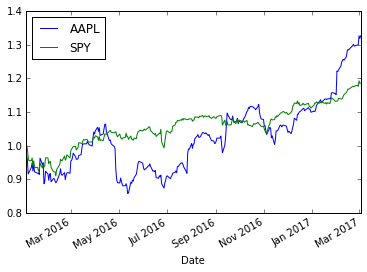

In [11]:
pair = closes[['AAPL', 'SPY']]
pair.div(pair.ix[0,:]).plot()

Now let's create the Kalman Filter model and get the current state of the model. 

In [12]:
kf = sm.KalmanOLS(dataset = closes[['AAPL', 'SPY']])

<p>The KalmanOLS model has a function that let's us grab the current state of the model. The information we really care about here is the <i>mean</i> which describes the model's current estimate of the hedge ratio and intercept of our pairs trading model</p>

In [13]:
kf.getState()

{u'cov': [[0.005189436104539258, -1.2330712005856919],
  [-1.2330712005856919, 293.98884752492955]],
 u'mean': [0.5862619781348402, 0.0034064598573656443]}

<p>In particular, the first element of the mean, i.e. 0.586, represents our current best hedge ratio. The second element is the current estimate of the intercept of the OLS model underpinning our pairs trade.</p>

<p>We can get the historical hedge ratios over the life of the model with the next function:</p>

In [14]:
historical_state = kf.getTrainingData()

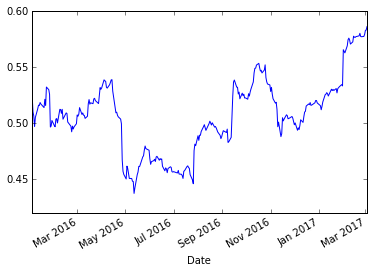

In [15]:
hedge_ratios = pd.DataFrame(historical_state['means'], index = closes.index, columns = ["beta", "alpha"])
hedge_ratios['beta'].plot()
plt.show()

<p>We can see that the hedge ratio has been rising in the near term</p>

<p>Let's do a quick sanity check on these hedge ratios, always a good idea before loading into a live trading strategy!!</p>

In [16]:
closes[['AAPL', 'SPY']].tail()

,AAPL,SPY
Date,,
2017-02-27,136.929993,237.110001
2017-02-28,136.990005,236.470001
2017-03-01,139.789993,239.779999
2017-03-02,138.960007,238.270004
2017-03-03,139.779999,238.419998


In [17]:
238.419998 * 0.586 + 0.003

139.71711882799997

<p>Now here comes the really cool part... <b>dynamic hedge ratios!</b></p>
<p>As we saw in the introductory story, and as any seasoned pairs trader knows, the hedge ratio is likely to change over time as the market conditions change. Luckily the KalmanOLS model has a built in function to ingest new price information and update the hedge ratio automatically.</p>

<p>For example, suppose these are the next two prices we observe for AAPL and SPY:</p>

In [18]:
aapl_px = 139.34
spy_px  = 237.97

In [19]:
kf.update(X = spy_px, Y = aapl_px)

{u'cov': [[0.005226738319753954, -1.23960489716516],
  [-1.2396048971651596, 294.9888048341461]],
 u'mean': [0.5855217106683254, 0.0034016229939260647]}

<p>Now we can feed the new hedge ratio, 0.585, into our trading strategy and update our hedges with SPY accordingly. Since <a href = "http://www.slicematrix.com">SliceMatrix-IO</a> is a Platform as a Service (PaaS) traders can use advanced machine learning models to quickly scale a trading operation. One could easily see how you could create multiple dynamic hedge ratios across the entire market with just a few lines of code.</p>